# ELT GPS Retroescavadeira
## 1. Extract
1.1. If dont have parquet file it will come from gsheet
## 2.Load
2.1. Load and convert in df pandas
## 3. Transform
3.1. Normalize de dataframe


Nestre exemplo os dados coletados em 2022 fornecidos pelo gps da retroscavadeira JCB 3CX, foram armazenados em um unico arquivo em formato de gsheet. Este estudo tem por finalidade **obter informação** utilizando tecnica da engenharia de dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
import extrair as extrair
import fx_data as fx_data
import filtros as filtros

In [3]:
#silver
#tranformar
df = pd.read_parquet('data/bronze_jcb_relatorio_2022.parquet',engine='pyarrow')
remover_colunas = ['id','hyperlink','maps_google_url']
df1 = fx_data.df_bronze_to_silver_gps(df=df,remover_colunas=remover_colunas)
df1.head(5)

,data_hora,atividade,gps_ativo,data,hora,minuto,nome_dia,lat,lon,lat_lon,lat_ant,lon_ant,raio_m,motor_ligado
0,2022-01-01 11:56:00,estado_activo,False,2022-01-01,11,56,saturday,-25.570758,-49.196145,-25.5707582|-49.1961449,NaN,NaN,NaN,False
1,2022-01-01 11:56:00,ligado,False,2022-01-01,11,56,saturday,-25.570758,-49.196145,-25.5707582|-49.1961449,-25.570758,-49.196145,0.0,False
19,2022-01-01 12:56:00,prestes_a_entrar_em_estado_de_descanso,True,2022-01-01,12,56,saturday,-25.570774,-49.196087,-25.5707737|-49.1960868,-25.570770,-49.196085,0.0,False
21,2022-01-02 00:56:00,estado_activo,False,2022-01-02,0,56,sunday,-25.570774,-49.196087,-25.5707737|-49.1960868,-25.570774,-49.196087,0.0,False
22,2022-01-02 00:56:00,ligado,False,2022-01-02,0,56,sunday,-25.570774,-49.196087,-25.5707737|-49.1960868,-25.570774,-49.196087,0.0,False


In [4]:
df2 = df1.query('motor_ligado==True')
display(df2.head(5))
display(df2['nome_dia'].value_counts())
display(df2['hora'].value_counts().sort_index())
df3 = df1.query('(motor_ligado==True) and (nome_dia=="sunday")')
display(df3['hora'].value_counts().sort_index())
display(df3.head(25))

,data_hora,atividade,gps_ativo,data,hora,minuto,nome_dia,lat,lon,lat_lon,lat_ant,lon_ant,raio_m,motor_ligado
70,2022-01-05 08:37:00,chave_ligada,False,2022-01-05,8,37,wednesday,-25.570799,-49.196091,-25.5707991|-49.1960913,-25.570799,-49.196091,0.0,True
71,2022-01-05 08:37:00,ligado,False,2022-01-05,8,37,wednesday,-25.570799,-49.196091,-25.5707991|-49.1960913,-25.570799,-49.196091,0.0,True
72,2022-01-05 08:37:00,arranque_do_motor,False,2022-01-05,8,37,wednesday,-25.570799,-49.196091,-25.5707991|-49.1960913,-25.570799,-49.196091,0.0,True
89,2022-01-05 13:51:00,chave_ligada,False,2022-01-05,13,51,wednesday,-25.570302,-49.196398,-25.5703022|-49.1963979,-25.570302,-49.196398,0.0,True
90,2022-01-05 13:51:00,ligado,False,2022-01-05,13,51,wednesday,-25.570302,-49.196398,-25.5703022|-49.1963979,-25.570302,-49.196398,0.0,True


friday       7701
monday       7600
thursday     7584
wednesday    7307
tuesday      7240
saturday     3084
sunday        245
Name: nome_dia, dtype: Int64

5        9
6      146
7     4759
8     5285
9     4130
10    5212
11    2972
12    1637
13    4717
14    4089
15    3711
16    2555
17    1129
18     328
19      57
20      17
21       8
Name: hora, dtype: int64

6      2
7     11
8     44
9     19
10    57
11    24
13    30
14    18
15     2
16     9
17    17
18     7
19     5
Name: hora, dtype: int64

,data_hora,atividade,gps_ativo,data,hora,minuto,nome_dia,lat,lon,lat_lon,lat_ant,lon_ant,raio_m,motor_ligado
27161,2022-07-17 08:01:00,chave_ligada,False,2022-07-17,8,1,sunday,-26.602457,-51.096624,-26.6024571|-51.0966244,-26.602457,-51.096624,0.0,True
27162,2022-07-17 08:01:00,arranque_do_motor,False,2022-07-17,8,1,sunday,-26.602457,-51.096624,-26.6024571|-51.0966244,-26.602457,-51.096624,0.0,True
34953,2022-09-04 11:24:00,chave_ligada,False,2022-09-04,11,24,sunday,-26.603237,-51.097721,-26.6032373|-51.0977211,-26.603237,-51.097721,0.0,True
34954,2022-09-04 11:24:00,ligado,False,2022-09-04,11,24,sunday,-26.603237,-51.097721,-26.6032373|-51.0977211,-26.603237,-51.097721,0.0,True
34955,2022-09-04 11:24:00,arranque_do_motor,False,2022-09-04,11,24,sunday,-26.603237,-51.097721,-26.6032373|-51.0977211,-26.603237,-51.097721,0.0,True
34957,2022-09-04 11:26:00,em_andamento,True,2022-09-04,11,26,sunday,-26.605413,-51.098191,-26.6054133|-51.0981914,-26.605413,-51.098191,0.0,True
34958,2022-09-04 11:26:00,em_andamento,True,2022-09-04,11,26,sunday,-26.605532,-51.098401,-26.6055325|-51.0984013,-26.605413,-51.098191,25.0,True
34959,2022-09-04 11:29:00,parado,True,2022-09-04,11,29,sunday,-26.604774,-51.099611,-26.6047735|-51.0996108,-26.605532,-51.098401,147.0,True
34960,2022-09-04 11:36:00,em_andamento,True,2022-09-04,11,36,sunday,-26.604891,-51.099347,-26.6048906|-51.0993469,-26.604774,-51.099611,29.0,True
34964,2022-09-04 11:40:00,chave_ligada,True,2022-09-04,11,40,sunday,-26.605310,-51.099269,-26.60531|-51.0992694,-26.605297,-51.099276,2.0,True


In [5]:
df3 = df1[df1['atividade'] == 'chave_ligada'].groupby(['data', 'atividade'])['hora'].first().reset_index()
display(df3)
display(df3['hora'].value_counts().sort_index())
df3['data'].nunique()

,data,atividade,hora
0,2022-01-05,chave_ligada,8
1,2022-01-07,chave_ligada,11
2,2022-01-10,chave_ligada,8
3,2022-01-12,chave_ligada,8
4,2022-01-20,chave_ligada,16
...,...,...,...
464,2023-08-25,chave_ligada,7
465,2023-08-28,chave_ligada,7
466,2023-08-29,chave_ligada,7
467,2023-08-30,chave_ligada,8


5       4
6      40
7     339
8      36
9       9
10     13
11      7
12      3
13      6
14      1
15      1
16      2
17      5
18      1
19      2
Name: hora, dtype: int64

469

In [6]:
#salvar 
caminho = 'C:\\Users\\User\\Documents\\GitHub\\gps_maquina\\data\\' 
arquivo = 'silver_jcb_relatorio_2022.parquet'
df1.to_parquet(caminho+arquivo, index=False)

In [7]:
#%%timeit
hora = 15
atividade = 'arranque_do_motor'
atividades = ['arranque_do_motor','paragem_do_motor']
consultas = [
    '(atividade == @atividade) and (hora==12)',
    '(atividade == @atividade) & (hora==12) and (nome_dia=="sunday")',
    '(atividade == @atividade) & (hora==12) or (nome_dia=="sunday") or (nome_dia=="saturday")',
    '(atividade == @atividades) & (hora==12)',
]

'premissas de comportamento fora da normalidade'
comportamentos = [
    {'nome':'chave ligada a noite','query':'(atividade == "chave_ligada") and (hora>18)'},
    {'nome':'chave ligada madrugada','query':'(atividade == "chave_ligada") and (hora>18)'}
]

df1.query(consultas[3])

,data_hora,atividade,gps_ativo,data,hora,minuto,nome_dia,lat,lon,lat_lon,lat_ant,lon_ant,raio_m,motor_ligado
917,2022-01-26 12:02:00,paragem_do_motor,True,2022-01-26,12,2,wednesday,-26.603210,-51.097669,-26.6032103|-51.0976689,-26.603210,-51.097669,0.0,False
1251,2022-01-31 12:33:00,arranque_do_motor,False,2022-01-31,12,33,monday,-26.603274,-51.097756,-26.603274|-51.0977558,-26.603274,-51.097756,0.0,True
1263,2022-01-31 12:47:00,paragem_do_motor,True,2022-01-31,12,47,monday,-26.606212,-51.098207,-26.6062118|-51.0982073,-26.606212,-51.098207,0.0,False
1383,2022-02-01 12:32:00,arranque_do_motor,False,2022-02-01,12,32,tuesday,-26.603247,-51.097748,-26.603247|-51.0977483,-26.603247,-51.097748,0.0,True
1486,2022-02-02 12:30:00,arranque_do_motor,False,2022-02-02,12,30,wednesday,-26.603232,-51.097736,-26.6032318|-51.0977359,-26.603232,-51.097736,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86125,2023-08-04 12:14:00,paragem_do_motor,True,2023-08-04,12,14,friday,-26.600265,-51.098044,-26.6002648|-51.0980436,-26.600265,-51.098044,0.0,True
87214,2023-08-17 12:55:00,arranque_do_motor,False,2023-08-17,12,55,thursday,-26.600342,-51.098177,-26.6003423|-51.0981766,-26.600342,-51.098177,0.0,True
87216,2023-08-17 12:57:00,paragem_do_motor,True,2023-08-17,12,57,thursday,-26.600204,-51.097874,-26.6002043|-51.0978744,-26.600147,-51.097943,9.0,True
87219,2023-08-17 12:58:00,arranque_do_motor,True,2023-08-17,12,58,thursday,-26.600210,-51.097884,-26.6002105|-51.0978838,-26.600210,-51.097883,0.0,True


### encontrar o quando a maquina esteve em operação
1. horario
2. dia da semana

{'dia': {'query': '7<=hora<=17', 'qtd': 11900, '%': 98.48, 'ativo': 1}}

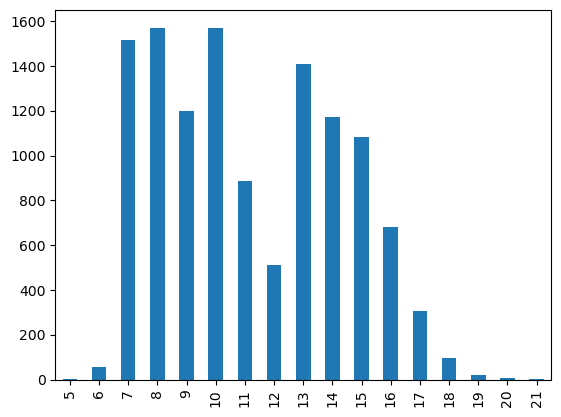

In [8]:
def turno_atividade(atividade:str,df:pd.DataFrame)->dict:
    """
    Encontrar o horario de operação de uma atividade:   
    """
    df1 = df.query(f'atividade =="{atividade}"')
    total_linhas = df1.shape[0]
    
    turnos = {
        'magrudada':{'query':'0<=hora<=6','qtd':0,'%':0},
        'dia':{'query':'7<=hora<=17','qtd':0,'%':0},
        'noite':{'query':'18<=hora<=23','qtd':0,'%':0},
        }
    for k,v in turnos.items():
        turnos[k]['qtd'] = len(df1.query(v['query']))
        turnos[k]['%'] = round((turnos[k]['qtd']/total_linhas)*100,2)
        turnos[k]['ativo']= 1 if turnos[k]['%']>5 else 0
    
    df1['hora'].value_counts().sort_index(ascending=True).plot(kind='bar')
    
    turno_ativo = {k: v for k, v in turnos.items() if v['ativo'] > 0}
    
    return turno_ativo
turnos_arranque_motor = turno_atividade(atividade='arranque_do_motor',df=df1)
display(turnos_arranque_motor)

{'wednesday': 18,
 'friday': 20,
 'monday': 18,
 'thursday': 18,
 'tuesday': 18,
 'saturday': 7}

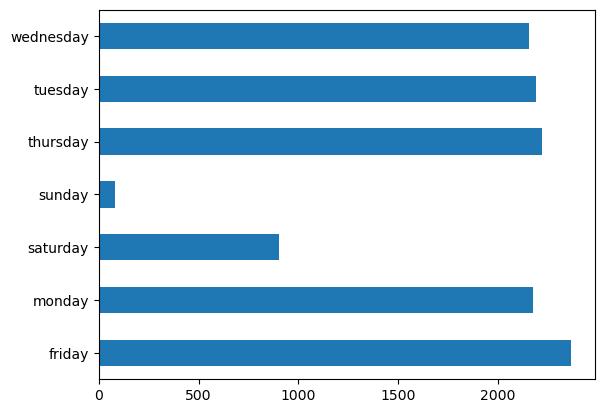

In [9]:
def dia_semana_atividade(atividade:str,df:pd.DataFrame)->dict:
    df1 = df.query(f'atividade =="{atividade}"')
    total_linhas = df1.shape[0]
     
    dic = {}
    dias_semana = df1['nome_dia'].unique().tolist()
    for dia in dias_semana:
        
        dic[dia]=len(df1.query(f'nome_dia =="{dia}"'))
        dic[dia] =round(dic[dia]/total_linhas,2)
        dic[dia] = int(dic[dia]*100)
        dia_ativo = {day: value for day, value in dic.items() if value > 5}
        
        df1['nome_dia'].value_counts().sort_index(ascending=True).plot(kind='barh')
        
    return dia_ativo

dia_arranque_motor = dia_semana_atividade(atividade='arranque_do_motor',df=df1)
    
display(dia_arranque_motor)
    

### quais os locais a maquina esteve desativada

In [10]:
df2 = df1.loc[(df1['hora'] > 20) | (df1['hora'] < 4)| (df1['atividade'] =='arranque_do_motor')]
display(df2.head(5))
unicos_lat_lon = df2['lat_lon'].unique()
display(unicos_lat_lon)
display(len(unicos_lat_lon))


,data_hora,atividade,gps_ativo,data,hora,minuto,nome_dia,lat,lon,lat_lon,lat_ant,lon_ant,raio_m,motor_ligado
21,2022-01-02 00:56:00,estado_activo,False,2022-01-02,0,56,sunday,-25.570774,-49.196087,-25.5707737|-49.1960868,-25.570774,-49.196087,0.0,False
22,2022-01-02 00:56:00,ligado,False,2022-01-02,0,56,sunday,-25.570774,-49.196087,-25.5707737|-49.1960868,-25.570774,-49.196087,0.0,False
26,2022-01-02 01:03:00,prestes_a_entrar_em_estado_de_descanso,True,2022-01-02,1,3,sunday,-25.570800,-49.196139,-25.5708002|-49.1961389,-25.570800,-49.196139,0.0,False
33,2022-01-03 01:09:00,estado_activo,False,2022-01-03,1,9,monday,-25.570759,-49.196103,-25.5707591|-49.1961034,-25.570759,-49.196103,0.0,False
34,2022-01-03 01:09:00,ligado,False,2022-01-03,1,9,monday,-25.570759,-49.196103,-25.5707591|-49.1961034,-25.570759,-49.196103,0.0,False


<StringArray>
['-25.5707737|-49.1960868', '-25.5708002|-49.1961389',
 '-25.5707591|-49.1961034', '-25.5707567|-49.1961021',
 '-25.5707727|-49.1961461', '-25.5707904|-49.1960554',
 '-25.5707991|-49.1960913', '-25.5703022|-49.1963979',
 '-25.5702212|-49.1963969', '-25.5702852|-49.1965478',
 ...
  '-26.601828|-51.0966156',  '-26.601946|-51.0965879',
 '-26.6019743|-51.0965824', '-26.6023356|-51.0965724',
 '-26.6028598|-51.0957261', '-26.6026206|-51.0959228',
 '-26.6025118|-51.0961009', '-26.6002381|-51.0978863',
 '-26.6026931|-51.0959506', '-26.6026995|-51.0959171']
Length: 12368, dtype: string

12368

### Grafico de Posicionamento x,y
Utilizando as coordenadas lat e lon e convertendo em um grafico de x,y para entender as regiões nas quais o equimamento esteve mais presente durante o periodo

<Axes: xlabel='lon', ylabel='lat'>

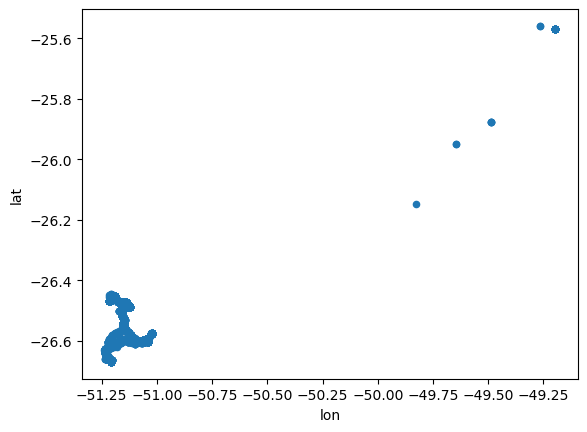

In [11]:
df1.plot.scatter(x='lon',y='lat')#, marker='o', color='blue', s=50, alpha=0.5)

# Add labels and title
#plt.xlabel('Latitude')
#plt.ylabel('Longitude')
#plt.title('Scatter Plot of Latitude vs. Longitude')

# Show the plot
#plt.show()

<Axes: xlabel='lat', ylabel='lon'>

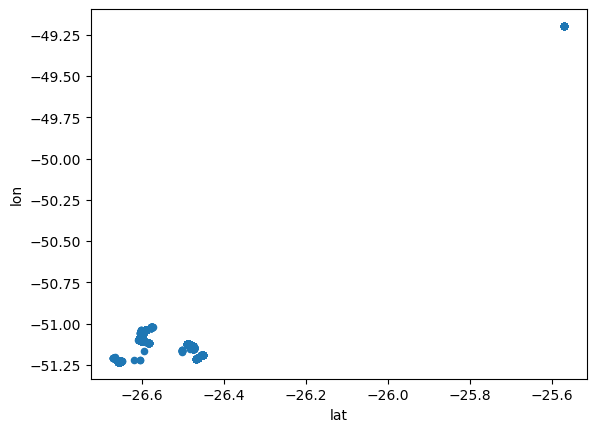

In [12]:
df2.plot.scatter(x='lat', y='lon')#, marker='o', color='blue', s=50, alpha=0.5)

### calcular a distancia a partir de pontos conhecidos


In [13]:
dic = extrair.json_to_dic('variaveis.json')
#display(dic['locais'])
df_locais = pd.DataFrame(dic['locais'])

display(df_locais)

,nome,lat,lon,raio,cor
0,cant_1,-26.603245,-51.097630,10,#ffaa00
1,cant_2,-26.600224,-51.098041,10,#ffaa00
2,posto_calmon,-26.599158,-51.096548,10,#ffaa00
3,posto_mite,-26.472965,-51.140994,10,#ffaa00
4,pedreira_denilson,-26.487208,-51.125129,10,#ffaa00


## grafico por mes!!

In [14]:
def df_count_query_merge(df:pd.DataFrame,coluna:str,querys:dict)->pd.DataFrame:
    
    i=0
    for nome,query in querys.items():
        if i==0:
            df1 = df.query(query)
            df1 = df1[coluna].value_counts().reset_index()
            df1.columns=['nome_dia',nome]
        else:
            df2 = df.query(query)
            #display(i,query,df2)
            df2 = df2[coluna].value_counts().reset_index()
            df2.columns=['nome_dia',nome]
            df3 = pd.merge(df2,df1,on='nome_dia',how='outer')
            #display(i,df2,df1)
            df1=df3
        i+=1
    df3.set_index('nome_dia',inplace=True)
    days_order = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
    df3 = df3.reindex(index=days_order)
    return df3

querys = {
    'motor_on':'atividade == "arranque_do_motor"',
    'motor_off':'atividade == "paragem_do_motor"',
    'chave_on':'atividade == "chave_ligada"',
    'chave_off':'atividade == "chave_desligada"',
}
df3 = df_count_query_merge(df1,'nome_dia',querys)
df3

,chave_off,chave_on,motor_off,motor_on
nome_dia,,,,
sunday,81,81,81,81
monday,2207,2207,2173,2173
tuesday,2216,2216,2189,2189
wednesday,2179,2179,2152,2152
thursday,2242,2242,2221,2221
friday,2391,2391,2364,2364
saturday,920,920,904,904


In [15]:
def count_weed_by_name(start, end) -> pd.DataFrame:
    
    serie = pd.date_range(start, end)
    serie = serie.day_name().str.lower()
    serie = serie.value_counts()
    order = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
    serie = serie.reindex(order)
    df = pd.DataFrame({'qtd':serie})
    df.rename_axis('nome_dia', inplace=True)
    
    return df

# Example usage:
start_date = '2022-01-01'
end_date = '2022-08-01'
df_dia = count_weed_by_name(start_date, end_date)
df_dia.T

nome_dia,sunday,monday,tuesday,wednesday,thursday,friday,saturday
qtd,31,31,30,30,30,30,31


In [16]:
df4 = df3.div(df_dia['qtd'],axis=0).astype(int)
df4

,chave_off,chave_on,motor_off,motor_on
nome_dia,,,,
sunday,2,2,2,2
monday,71,71,70,70
tuesday,73,73,72,72
wednesday,72,72,71,71
thursday,74,74,74,74
friday,79,79,78,78
saturday,29,29,29,29


In [17]:
df4 = df4.median(axis=1).astype(int)
df4

nome_dia
sunday        2
monday       70
tuesday      72
wednesday    71
thursday     74
friday       78
saturday     29
dtype: int32

In [18]:
df4.describe().astype(int)


count     7
mean     56
std      29
min       2
25%      49
50%      71
75%      73
max      78
dtype: int32

In [19]:
df4

nome_dia
sunday        2
monday       70
tuesday      72
wednesday    71
thursday     74
friday       78
saturday     29
dtype: int32

In [20]:
analise=fx_data.PeriodoDataFrame(df1)
df_weekday =analise.count_weekdays() 
df_weekday

,qtd,dia_util
nome_dia,,
sunday,87,False
monday,87,True
tuesday,87,True
wednesday,87,True
thursday,87,True
friday,86,True
saturday,87,False


In [21]:
analise.qtd_med_weekdays

87.0

In [23]:
a=87.55
display(int(a))

87